# POB Lab 14 Face detection and recognition

### Imports

In [4]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from matplotlib import pyplot as plt


#Credits:
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
# https://github.com/theAIGuysCode/colab-webcam
# https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/
# https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

In [5]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN

In [1]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

ModuleNotFoundError: ignored

In [ ]:
from matplotlib import pyplot
from PIL import Image as Img
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras import applications
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

import ipywidgets as widgets
import PIL.Image
import io
#!pip install deepface
from deepface import DeepFace

In [ ]:
#!pip install mtcnn

#!pip install git+https://github.com/rcmalli/keras-vggface.git
#!pip install keras_applications==1.0.4 --no-deps

!pip install keras==2.4.3
!pip install keras-vggface==0.6
!pip install keras_applications==1.0.8

### Helper functions

In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

      center = (x + w//2, y + h//2)
      img = cv2.ellipse(img, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
      faceROI = gray[y:y+h,x:x+w]
      #-- In each face, detect eyes
      eyes = eyes_cascade.detectMultiScale(faceROI)
      for (x2,y2,w2,h2) in eyes:
          eye_center = (x + x2 + w2//2, y + y2 + h2//2)
          radius = int(round((w2 + h2)*0.25))
          img = cv2.circle(img, eye_center, radius, (255, 0, 0 ), 4)

  # save image
  cv2.imwrite(filename, img)

  return filename

# Face detection


## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model. 

In [8]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml') # haarcascade_eye_tree_eyeglasses  haarcascade_eye

#detectAndDisplay(image)


<IPython.core.display.Javascript object>

(480, 640)
Saved to photo2.jpg


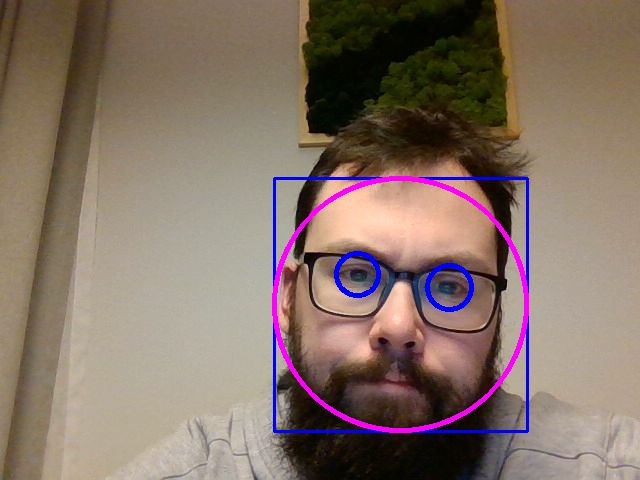

In [9]:
try:
  filename = take_photo('photo2.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Webcam Live Stream
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

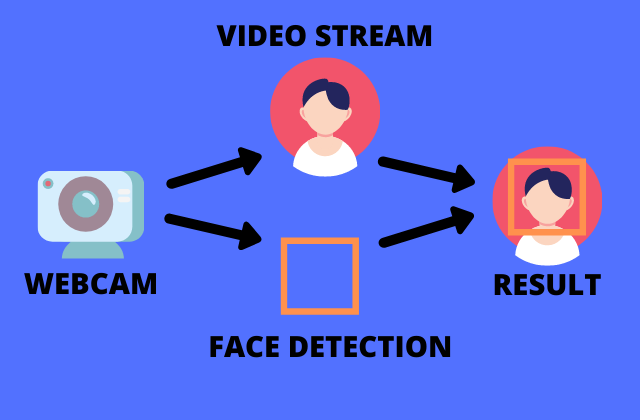</center>

In [7]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [8]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray,1.1, 8)
    
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,0,255),2)

      center = (x + w//2, y + h//2)
      #bbox_array = cv2.ellipse(bbox_array, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
      faceROI = gray[y:y+h,x:x+w]
      #-- In each face, detect eyes
      eyes = eyes_cascade.detectMultiScale(faceROI)
      for (x2,y2,w2,h2) in eyes:
          eye_center = (x + x2 + w2//2, y + y2 + h2//2)
          radius = int(round((w2 + h2)*0.25))
          bbox_array = cv2.circle(bbox_array, eye_center, radius, (255, 0, 0 ), 4)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

## Deep learning Face detection


     |████████████████████████████████| 2.3 MB 5.4 MB/s 


0.1.0


In [ ]:

# face detection with mtcnn on a photograph

 
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
		# draw the dots
		for key, value in result['keypoints'].items():
			# create and draw dot
			dot = Circle(value, radius=2, color='red')
			ax.add_patch(dot)
	# show the plot
	pyplot.show()
 
filename = 'photo.jpg'
# load image from file
pixels = pyplot.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_image_with_boxes(filename, faces)

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

detector = MTCNN()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #cv2_imshow(gray)
    
    # detect faces in the image
    faces = detector.detect_faces(img)

    #print(faces[0]['box'])

    for face in faces:
      x, y, width, height = face['box']
      # create the shape
      center = (x + width//2, y + height//2)
      #bbox_array = cv2.ellipse(bbox_array, center, (w//2, h//2), 0, 0, 360, (255, 0, 0), 2)
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+width,y+height),(0,255,0),2)

      for key, value in face['keypoints'].items():
        # create and draw dot
        #dot = Circle(value, radius=2, color='red')
        #radius = int(round((w2 + h2)*0.25))
        bbox_array = cv2.ellipse(bbox_array, value, (3, 3), 0, 0, 360, (0, 0, 255), 4)
        
  
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

# Face verification

## VGGFace2

  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.4.3 which is incompatible.


     |████████████████████████████████| 50 kB 2.6 MB/s 
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.4
    Uninstalling Keras-Applications-1.0.4:
      Successfully uninstalled Keras-Applications-1.0.4


In [11]:
# face verification with the VGGFace2 model

 
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Img.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat
 
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
 


In [13]:
# define filenames
filenames = ['photo.jpg', 'photo2.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define sharon stone
sharon_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
#is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests')
#is_match(embeddings[0], embeddings[3])

Positive Tests
>face is a Match (0.129 <= 0.500)
Negative Tests


In [16]:

btn_run = widgets.Button(description='Identify celeb')
lbl_pred = widgets.Label()
out_pl = widgets.Output()

In [17]:
def on_click_classify(change):
    img = cv2.imdecode(np.frombuffer(btn_upload.data[-1], np.uint8), -1)
    pred, img = get_celeb_prediction_new_1(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    out_pl.clear_output()
    with out_pl: display(im_pil)
    celebs = [c["celeb_name"] for c in pred]
    lbl_pred.value = 'Prediction: {}'.format(celebs)

btn_run.on_click(on_click_classify)

In [18]:
btn_upload = widgets.FileUpload(multiple=False)
widgets.VBox([btn_upload, btn_run, out_pl, lbl_pred])

NameError: ignored

## Deep Face

In [ ]:
#!pip install deepface
from deepface import DeepFace
obj = DeepFace.verify([
      ["img1.jpg", "img2.jpg"],
      ["img1.jpg", "img3.jpg"],
      ["img1.jpg", "img4.jpg"],
   ]
   , model_name = "VGG-Face")
print(obj)

In [ ]:
front_camera = CameraStream.facing_user(audio=False)
image_recorder = ImageRecorder(stream=front_camera)
image_recorder

In [ ]:

im = PIL.Image.open(io.BytesIO(image_recorder.image.value))
im_array = np.array(im)